# Decision Trees

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
from IPython.display import display
%matplotlib inline

In [ ]:
toy_data = pd.read_csv("tennis.csv.txt")
toy_data

### A decision tree for data above

<img src="https://github.com/awantik/machine-learning-slides/blob/master/dt4.PNG?raw=true" width="600px">

### 2. Decision Tree Algorithms

| Feature                | ID.3 (Ross Quinlan et al.)    | CART (Leo Breiman et al.)     | C4.5, C5 (Ross Quinlan et al.) |
|------------------------|-------------------------------|-------------------------------|-------------------------------|
| **Splitting Criterion**| Information Gain              | Gini (classification) / Variance (regression) | Gain Ratio                   |
| **Data Types**         | Categorical only              | Categorical + Continuous      | Categorical + Continuous      |
| **Tree Structure**     | Multi-way                     | Binary                        | Multi-way for categorical features, binary for numerical           |
| **Pruning**            | None                          | Cost-complexity               | Pessimistic pruning           |
| **Task Support**       | Classification                | Classification + Regression   | Classification                |
| **Overfitting**        | High (no pruning)             | Moderate (pruning, binary splits) | Low (pruning, gain ratio) |
| **Missing Values**     | Not handled                   | Surrogate splits              | Fractional instances          |

**scikit-learn decision trees are based on CART**

## Splitting Criterions a.k.a Impurity measures

In the decision tree, each node corresponds to a subset of the train data $S$. Let $\{p_i\}_{i=1}^C$ be the target distribution over $C$ classes for this subset $S$.

* __Entropy:__ $H(S) = -\sum p_i\log(p_i)$
* __Gini Index:__ $Gini(S) = 1-\sum p_i^2$

> NOTE: the perfomance is usually similar, it doesn't matter which one to chose

These are an **Impurity measures** of single node, now we want to select an optimal split. For candidate $S=S_1 \sqcup S_2 \dots \sqcup S_{K_A}$ respecting the values of feature $A$

* __Information gain__, aka mutual information $$IG(S, A) = H(S) - H(S|A) = I(S;A) = \sum_{i=1}^{K_A}\frac{|S_i|}{|S|}H(S_i)$$
> NOTE: What are the limits of IG values? Can it be nega
* __Gain Ratio__: $$GainRatio(S, A) = IG(S, A) \cdot \frac{1}{-\sum_{i=1}^{K_A} \frac{|S_i|}{|S|}\log\frac{|S_i|}{|S|}}$$


# Manual Construction for the toy data

### Entropy of play

In [ ]:
toy_data

In [ ]:
toy_data.play.value_counts()

In [ ]:
# entropy = - E(log_p)
Entropy_Play = -5 / 14 * np.log(5 / 14) - 9 / 14 * np.log(9 / 14)
Entropy_Play

#### Information Gain on splitting by Outlook


In [ ]:
toy_data[toy_data.outlook == "sunny"]

In [ ]:
# Entropy(Play|Outlook=Sunny)
Entropy_Play_Outlook_Sunny = -2 / 5 * np.log(2 / 5) - 3 / 5 * np.log(3 / 5)

In [ ]:
Entropy_Play_Outlook_Sunny

In [ ]:
toy_data[toy_data.outlook == "overcast"]

In [ ]:
# Entropy(Play|Outlook=overcast)
# Since, it's a homogenous data entropy will be 0

In [ ]:
toy_data[toy_data.outlook == "rainy"]

In [ ]:
# Entropy(Play|Outlook=rainy)
Entropy_Play_Outlook_Rain = -2 / 5 * np.log(2 / 5) - 3 / 5 * np.log(3 / 5)

In [ ]:
Entropy_Play_Outlook_Rain

#### Gain on splitting by attribute outlook

In [ ]:
Informatio_Gain = (
    Entropy_Play
    - 5 / 14 * Entropy_Play_Outlook_Sunny
    - 5 / 14 * Entropy_Play_Outlook_Rain
)
Informatio_Gain

#### Other gains
* Gain(Play, Temperature) - 0.029
* Gain(Play, Humidity) - 0.151
* Gain(Play, Wind) - 0.048

#### Conclusion - Outlook is winner & thus becomes root of the tree
<img src="https://i1.wp.com/sefiks.com/wp-content/uploads/2017/11/tree-v1.png?zoom=1.25&resize=728%2C252&ssl=1" width="600px">

### Time to find the next splitting criteria

In [ ]:
toy_data[toy_data.outlook == "overcast"]

##### Conclusion - If outlook is overcast, play is true

### Let's find the next splitting feature

In [ ]:
toy_data[toy_data.outlook == 'sunny']

In [ ]:
# Entropy(Play|Outlook=Sunny)
Entropy_Play_Outlook_Sunny = ...
Entropy_Play_Outlook_Sunny

### Information Gain for humidity

In [ ]:
...

### Information Gain for windy

In [ ]:
Entropy_Windy_False = ...
Entropy_Windy_True = ...
IG_Windy= ...

### Information Gain for temperature

In [ ]:
...

#### Conclusion : Humidity is the best choice on sunny branch

<img src="https://github.com/awantik/machine-learning-slides/blob/master/dt3.PNG?raw=true" width="600px">

# (repeat)

### Final Tree

<img src="https://github.com/awantik/machine-learning-slides/blob/master/dt4.PNG?raw=true" width="600px">

## Sklearn
[The guide on decision trees is awesome](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.datasets import make_blobs

In [ ]:
iris = load_iris()

In [ ]:
iris.data[:5]

In [ ]:
iris.target[:5]

In [ ]:
dt = DecisionTreeClassifier(criterion="entropy")

In [ ]:
# from sklearn.model_selection import train_test_split

In [ ]:
# trainX, testX, trainY, testY = train_test_split(iris.data, iris.target)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import pandas as pd
import graphviz

encoder = OrdinalEncoder()
toy_data_enc = encoder.fit_transform(toy_data.drop("play", axis=1))
dt.fit(toy_data_enc, toy_data["play"])

In [ ]:
tree = export_graphviz(dt)
graph = graphviz.Source(tree)
graph.render()
graph.view()

### Visualizing the tree
<img src="https://github.com/awantik/machine-learning-slides/blob/master/dt6.PNG?raw=true">

In [ ]:
dt.predict(testX)

> NOTE:
> * CART (which is used inside sklearn DecisionTreeClassifier) will convert features with continues values into categorical values
> * Different tree will be generated with same faeatures given in different order. This is because `max_features` algorithm and random feature subsampling inside.

#### Feature Importances
* Important features will be higher up the tree
> The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.
Warning: impurity-based feature importances can be misleading for high cardinality features (many unique values). See sklearn.inspection.permutation_importance as an alternative.



In [ ]:
dt.feature_importances_

#### Visualizing Decision Boundry

In [ ]:
X, Y = make_blobs(
    n_features=2, n_samples=1000, cluster_std=0.8, centers=4, random_state=6
)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=Y, s=5, cmap="viridis")

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(X, Y)

In [ ]:
plot_step = 0.2
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
)

In [ ]:
outcome = dt.predict(np.c_[xx.ravel(), yy.ravel()])

In [ ]:
xx.shape

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=Y, s=5, cmap="viridis")
plt.scatter(xx.ravel(), yy.ravel(), c=outcome, s=1, alpha=1, cmap="viridis")
plt.show()

<img src="https://github.com/awantik/machine-learning-slides/blob/master/dt8.PNG?raw=true">

# ID3 Implementation

For now, we will focus on the ID3 algorithm. 

In [2]:
import numpy as np
import pandas as pd

# Load dataset and convert to DataFrame
dataset = {
    'Taste': ['Salty','Spicy','Spicy','Spicy','Spicy','Sweet','Salty','Sweet','Spicy','Salty'],
    'Temperature': ['Hot','Hot','Hot','Cold','Hot','Cold','Cold','Hot','Cold','Hot'],
    'Texture': ['Soft','Soft','Hard','Hard','Hard','Soft','Soft','Soft','Soft','Hard'],
    'Eat': ['No','No','Yes','No','Yes','Yes','No','Yes','Yes','Yes']
}
dataframe = pd.DataFrame(dataset, columns=['Taste','Temperature','Texture','Eat'])

# Prepare features and target
feature_names = dataframe.columns[:-1].tolist()
X = dataframe[feature_names].to_numpy()
y = dataframe['Eat'].to_numpy()
features = list(range(len(feature_names)))

dataframe.head(2)

,Taste,Temperature,Texture,Eat
0,Salty,Hot,Soft,No
1,Spicy,Hot,Soft,No


In [4]:
from typing import Dict, Any
from IPython.display import display
from graphviz import Digraph


def entropy(y: np.ndarray) -> float:
    """Calculate the entropy of a target array."""
    _, counts = np.unique(y, return_counts=True)
    probs = counts / y.shape[0]
    return -np.sum(probs * np.log(probs + 1e-10))


def information_gain(X: np.ndarray, y: np.ndarray, feature_idx: int) -> float:
    """Calculate the information gain for a given feature."""
    parent_entropy = entropy(y)

    values, counts = np.unique(X[:, feature_idx], return_counts=True)
    probs = counts / y.shape[0]
    entropies = np.array(
        list(map(lambda x: entropy(y[X[:, feature_idx] == x]), values))
    )
    conditional_entropy = np.sum(probs * entropies)

    return parent_entropy - conditional_entropy


def select_best_feature(X: np.ndarray, y: np.ndarray, features: list) -> list:
    """Select the feature with the highest information gain."""
    best_idx = np.argmax([information_gain(X, y, i) for i in range(X.shape[1])])
    return [best_idx, features[best_idx]]


def id3_algorithm(X: np.ndarray, y: np.ndarray, features: list) -> Dict[str, Any]:
    """Recursively build the ID3 decision tree."""
    classes, counts = np.unique(y, return_counts=True)

    majority_class = classes[np.argmax(counts)]

    # Base case: all samples same class
    if len(classes) == 1 or not features:
        return {"class": classes[0], "majority_class": classes[0]}

    best_id, best_feature = select_best_feature(X, y, features)
    feature_values = np.unique(X[:, best_id])
    new_features = features.copy()
    new_features.remove(best_feature)

    tree = {"feature": best_feature, "majority_class": majority_class, "children": {}}

    for value in feature_values:
        mask = X[:, best_id] == value
        X_sub, y_sub = np.delete(X, best_id, axis=1)[mask], y[mask]
        if len(y_sub) == 0:
            tree["children"][value] = {
                "class": majority_class,
                "majority_class": majority_class,
            }
        else:
            tree["children"][value] = id3_algorithm(X_sub, y_sub, new_features)

    return tree


def visualize_tree(
    tree: Dict[str, Any],
    feature_names: list,
    dot: Digraph = None,
    parent: str = None,
    edge_label: str = None,
) -> Digraph:
    """Recursively visualize the decision tree using Graphviz."""
    if dot is None:
        dot = Digraph(comment="Decision Tree")

    # Create a unique node ID
    node_id = str(id(tree))

    # Add the current node
    if "class" in tree:
        node_label = f"Class: {tree['class']}"
    else:
        node_label = f"Feature: {tree['feature']}"
    dot.node(node_id, node_label)

    # Connect to parent node if exists
    if parent is not None:
        dot.edge(parent, node_id, label=edge_label)

    # Recursively add children
    if "children" in tree:
        for value, child in tree["children"].items():
            visualize_tree(child, feature_names, dot, node_id, str(value))

    return dot


class DecisionTree:
    """
    Decision tree classifier, which can be trained, can predict class labels(miraculously) and display itself if used in a frontend environment.
    """

    def __init__(self):
        self._features = []
        self._tree = {}

    def fit(self, X: np.ndarray, y: np.ndarray, features: list) -> None:
        """Fit the decision tree to passed data."""
        self._features = features
        self._tree = id3_algorithm(X, y, features)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict class labels for given data."""
        ans = np.zeros((X.shape[0], 1), dtype="object")
        for i in range(ans.shape[0]):
            node = self._tree
            while "class" not in node:
                feature_id = self._features.index(node["feature"])
                if X[i, feature_id] in node["children"]:
                    node = node["children"][X[i, feature_id]]
                else:
                    break
            if "class" in node:
                ans[i, 0] = node["class"]
            else:
                ans[i, 0] = node["majority_class"]
        return ans

    def show_tree(self):
        """Visualize the decision tree."""
        dot = visualize_tree(self._tree, self._features)
        display(dot)

In [5]:
classifier = DecisionTree()
classifier.fit(X, y, feature_names.copy())

# New data point for prediction
new_data_point = np.array([["Salty", "Hot", "Hard"]], dtype="object")
prediction = classifier.predict(new_data_point)

print(f"Prediction for the new data point: {prediction}")

Prediction for the new data point: [['Yes']]


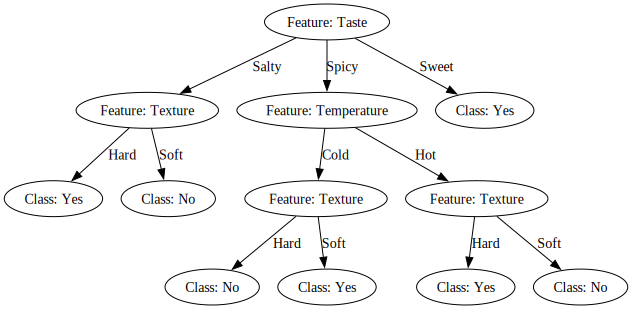

In [6]:
classifier.show_tree()

# Pruning
* Trees always tends to overfit
* A technique of machine learning which reduces height of the tree by chopping off parts of the tree that's not doing anything significant in prediction
* Prepruning & Postpruning
  - Prepruning : Don't allow tree to grow beyond this point (`min_leaf_size`, `max_depth`, `min_impurity_decrease`) --> **implement it in the code above if some time is left**
  - Postpruning : Allows tree to grow as much as possible, then prune the tree (`ccp_alpha`)

## The cost-complexity prunning
Cost-complexity measure:
$$
R_\alpha(T)=R(T)+\alpha∣T∣
$$

where:
* $R(T)$ - The misclassification error (or impurity) of the tree T on the training data.
* $|T∣$ - The number of terminal nodes (leaves) in the tree TT, representing its complexity.
* $\alpha$ - A tuning parameter that controls the trade-off between the tree's accuracy and complexity.

The we want to minimize the $R_\alpha$ over the space of subtrees of given tree T. 

> BWT, what kind of tree we will get if set $\alpha$ to $0, \infty$?

Greedy algorithm:
1. Build the full tree
2. For each node $t$ compute $R_\alpha(T_t)$ of corresponding subtree $T_t$ and $R_\alpha(t)$ of subtree collapsed into that node.
3. Prune the branch, if the $R_\alpha(T_t) < R_\alpha(T)$

> Do we need to recaclucate the $R_\alpha$ for non-prunned nodes?

In [ ]:
# implementation?

import copy

def compute_subtree_error(tree: Dict) -> int:
    """Calculate the total misclassification error of a subtree."""
    ...
    return total_error

def compute_subtree_leaves(tree: Dict) -> int:
    """Count the number of leaf nodes in a subtree."""
    ...
    return total_leaves

def collect_pruning_candidates(tree: Dict, candidates: list) -> None:
    """Collect non-leaf nodes with their effective alpha values."""
    ...

def cost_complexity_pruning(tree: Dict, alpha: float) -> Dict:
    """Prune the tree using cost-complexity pruning with parameter alpha."""
    
    return tree

In [ ]:
# Prune the tree with alpha=0.1 (adjust alpha based on your needs)
alpha = 0.1
pruned_tree = cost_complexity_pruning(decision_tree, alpha)

# Visualize the pruned tree in Jupyter Notebook
dot_pruned = visualize_tree(pruned_tree, feature_names)
display(dot_pruned)  # Display directly in the notebook

# Test prediction with the pruned tree
pruned_prediction = predict(pruned_tree, feature_names, new_data_point)
print(f"Pruned tree prediction: {pruned_prediction}")

# Random Forest

Prunnning your trees (like any other regularization technique) introduces a bias-variance tradeoff. Oversimplificated trees has larger bias (but low variance), overfitted trees has zero noise yet large variance. 

Random forest is one possible way to overcome this, it trains $n$ decision trees on subsets of the train data, sampled with repetitions, and then average predictions for these trees.

**Why it works?** For a simple demonstration, suppose that each of your trees has variance $\sigma^2$. As it was trained on a random subsets of the original data, it will be biased, but the distribution over this bias has zero mean and in average the overall bias is zero due to large number law. 

At the same time, variance of the whole ensemble is $$n\frac{\sigma^2}{n^2} + \text{covariance terms}$$

With growing N we have decreased bias and increased convariance terms, and we need to balance between them.

> Should I usee depth constraints or pruning inside forest?

In [ ]:
class DecisionTree():
    ...

In [ ]:
class RandomForestClassifier:
    def __init__(self, n_estimators=100, max_features='sqrt', max_depth=None):
        ...
    
    def fit(self, X, y):
        ...
    
    def predict(self, X):
        ...

In [ ]:
# Load sample data
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train random forest
rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=None)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

## Bonus Task 25: Prunning
Select any kind of prunning algorithms except for Cost-Complexity Prunnig (e.g. from [here](http://dspace.mit.edu/bitstream/handle/1721.1/6453/AIM-930.pdf?sequence=2)) and implement it.

## Bonus Task 26: Extra trees

Random forest isn't the only option to combine decision trees into ensembles. Your goal is to write a code for [`ExtraTrees`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html). In addition to that, explain the difference with RF and provide some insights on practical tips, like 
* should I use more trees?
* should I use deeper trees?
* etc.